# Day 3: Time-Based & Seasonal Features

## 🎯 Learning Objectives
- Calendar effects in markets
- Seasonal patterns
- Time encoding for ML

---

In [14]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

ticker = 'SPY'
end_date = datetime.now()
start_date = end_date - timedelta(days=20*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
df = data[['Close']].copy()
df['return'] = df['Close'].pct_change()
print(f"✅ Data: {len(df)} days")

📥 Downloading data...


✅ Data: 5027 days


In [15]:
# Time-based features
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['dayofweek'] = df.index.dayofweek  # 0=Monday
df['quarter'] = df.index.quarter
df['is_month_start'] = df.index.is_month_start.astype(int)
df['is_month_end'] = df.index.is_month_end.astype(int)
df['is_quarter_end'] = df.index.is_quarter_end.astype(int)

# Cyclical encoding
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['dow_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 5)
df['dow_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 5)

print(f"\n📊 Time features created")


📊 Time features created



DAY OF WEEK EFFECT
       mean     std  count
Mon  0.0003  0.0137    943
Tue  0.0008  0.0120   1032
Wed  0.0007  0.0120   1032
Thu  0.0002  0.0123   1011
Fri  0.0003  0.0110   1008


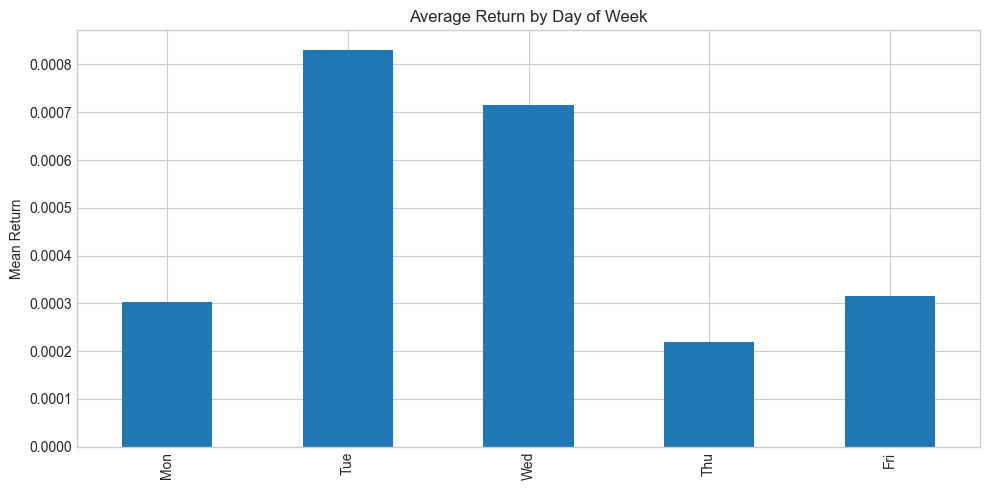

In [16]:
# Analyze day-of-week effect
dow_returns = df.groupby('dayofweek')['return'].agg(['mean', 'std', 'count'])
dow_returns.index = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']

print("\n" + "="*60)
print("DAY OF WEEK EFFECT")
print("="*60)
print(dow_returns.round(4))

fig, ax = plt.subplots(figsize=(10, 5))
dow_returns['mean'].plot(kind='bar', ax=ax)
ax.set_title('Average Return by Day of Week')
ax.set_ylabel('Mean Return')
plt.tight_layout()
plt.show()


MONTHLY SEASONALITY
       mean     std
Jan  0.0001  0.0105
Feb  0.0001  0.0108
Mar  0.0007  0.0168
Apr  0.0010  0.0127
May  0.0004  0.0103
Jun  0.0002  0.0106
Jul  0.0012  0.0085
Aug  0.0002  0.0112
Sep -0.0002  0.0116
Oct  0.0006  0.0161
Nov  0.0012  0.0136
Dec  0.0004  0.0107


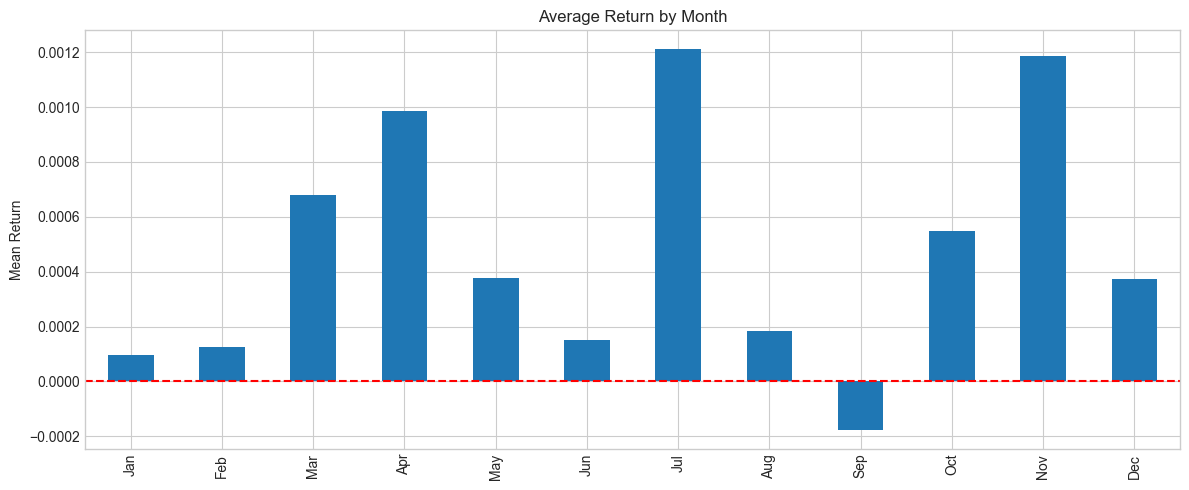

In [17]:
# Month-of-year effect ("Sell in May")
month_returns = df.groupby('month')['return'].agg(['mean', 'std'])
month_returns.index = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

print("\n" + "="*60)
print("MONTHLY SEASONALITY")
print("="*60)
print(month_returns.round(4))

fig, ax = plt.subplots(figsize=(12, 5))
month_returns['mean'].plot(kind='bar', ax=ax)
ax.set_title('Average Return by Month')
ax.set_ylabel('Mean Return')
ax.axhline(y=0, color='r', linestyle='--')
plt.tight_layout()
plt.show()

In [18]:
# Turn-of-month effect
tom_returns = df.groupby('is_month_start')['return'].mean()
eom_returns = df.groupby('is_month_end')['return'].mean()

print("\n" + "="*60)
print("TURN-OF-MONTH EFFECT")
print("="*60)
print(f"\nMonth Start Days: {tom_returns[1]:.4%}")
print(f"Other Days: {tom_returns[0]:.4%}")
print(f"\nMonth End Days: {eom_returns[1]:.4%}")
print(f"Other Days: {eom_returns[0]:.4%}")


TURN-OF-MONTH EFFECT

Month Start Days: 0.1086%
Other Days: 0.0462%

Month End Days: -0.0210%
Other Days: 0.0506%


In [19]:
# Build seasonality-based strategy
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

# Target
df['target'] = np.sign(df['return'].shift(-1))
df['target'] = df['target'].map({1: 1, -1: 0, 0: 1})

feature_cols = ['month_sin', 'month_cos', 'dow_sin', 'dow_cos', 
                'is_month_start', 'is_month_end', 'is_quarter_end']

df_model = df.dropna()

train_size = int(len(df_model) * 0.8)
train = df_model.iloc[:train_size]
test = df_model.iloc[train_size:]

X_train = train[feature_cols]
y_train = train['target']
X_test = test[feature_cols]
y_test = test['target']

model = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)
model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
print(f"\nTest Accuracy: {accuracy_score(y_test, model.predict(X_test)):.1%}")


Test Accuracy: 54.2%


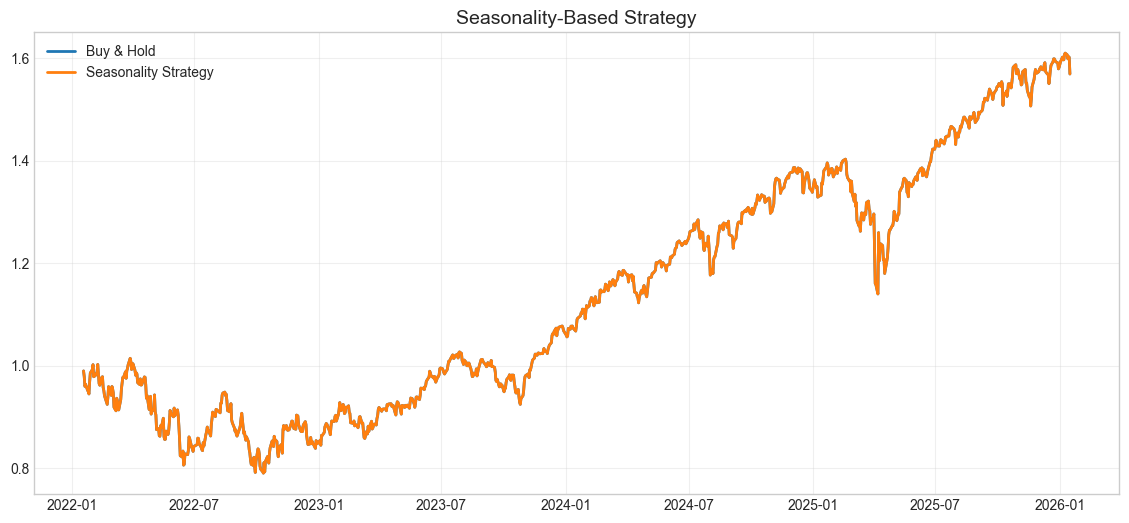

In [20]:
# Strategy performance
backtest = test.copy()
backtest['pred'] = model.predict(X_test).astype(int)
backtest['signal'] = backtest['pred'].map({1: 1, 0: -1})
backtest['next_return'] = backtest['return'].shift(-1)
backtest['strategy_return'] = backtest['signal'] * backtest['next_return']

backtest = backtest.dropna()
backtest['strategy_cum'] = (1 + backtest['strategy_return']).cumprod()
backtest['buy_hold_cum'] = (1 + backtest['next_return']).cumprod()

plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(backtest.index, backtest['strategy_cum'], label='Seasonality Strategy', linewidth=2)
plt.title('Seasonality-Based Strategy', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [21]:
# Today's seasonal signal
latest = df_model[feature_cols].iloc[[-1]]
pred = model.predict(latest)[0]

print("\n" + "="*60)
print(f"📊 SEASONAL SIGNAL FOR {ticker}")
print("="*60)
print(f"\nDate: {df_model.index[-1].strftime('%Y-%m-%d %A')}")
print(f"Month: {df_model.index[-1].strftime('%B')}")
print(f"Day of Week: {['Mon','Tue','Wed','Thu','Fri'][df_model['dayofweek'].iloc[-1]]}")
print(f"Month Start: {'Yes' if df_model['is_month_start'].iloc[-1] else 'No'}")
print(f"Month End: {'Yes' if df_model['is_month_end'].iloc[-1] else 'No'}")
print(f"\n🎯 Seasonal Signal: {'📈 BULLISH' if pred == 1 else '📉 BEARISH'}")


📊 SEASONAL SIGNAL FOR SPY

Date: 2026-01-20 Tuesday
Month: January
Day of Week: Tue
Month Start: No
Month End: No

🎯 Seasonal Signal: 📈 BULLISH


---
## 📅 Tomorrow: Feature Selection